<a href="https://colab.research.google.com/github/lsolomyak/AutoEncoderImageDenoise/blob/master/seismic_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls "/content/drive/My Drive/Team CGG/Data/synth_data/data_input/train"


'CGG docs'   Data   Documents   Meetings   Presentations  'Team Charter.gdoc'


### Introduction

>**note** we assume you have run through segy_import_npy_output and have the necessary npy files loaded and ready to go

In seismic data, a trace represents the recorded seismic energy as it travels through the Earth and is detected by a receiver. It's a continuous time series of amplitude values that reflect the subsurface geological structure. In the given code, the trace data is extracted from a SEGY file, which is a standard format for storing seismic data, and then plotted to visualize the waveform. This can provide insights into the properties and composition of underground layers, such as rock formations and potential hydrocarbon reservoirs.



the code has read a single 2D slice from the 3D SEGY file, corresponding to a specific inline. This 2D slice can be thought of as an "image" of the subsurface along that inline, with the horizontal axis representing crosslines and the vertical axis representing time or depth.

In [13]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
import random
import gc
#from patchify import patchify, unpatchify

In [ ]:
# double check the shape of the images

!ls drive/

The problem we have here is that our images are 501 x 3000 which are terrible numbers to work with- so we pad it by 504 before resizing for windows of 32x70-(those windows are arbitrary but hopefully allow for a kernel of 6x7)

- **Padding Function:**
  
>  -Probably wortwhile reading this on why padding is important https://www.geeksforgeeks.org/cnn-introduction-to-padding/#:~:text=padding%20is%20a%20technique%20used,input%20feature%20map%20before%20convolution.
  - This function pads an image to make its dimensions divisible by the window size.
  - Padding is added at the bottom and right edges of the image.

note- we save it as float32 which is easier for the cpu

- **Image to Windows Conversion Function:**
  - This function takes an image and divides it into non-overlapping windows of size \( h \times w \).
  - It uses the `pad_image` function to ensure that the dimensions are divisible by the window size.


In [11]:
def resize_image(image):
    # add 72 to x axis and 11 to y axis
    x_addition = np.zeros((72, 501))
    y_addition = np.zeros((3072, 11))
    image = np.concatenate((image, x_addition), axis=0)
    image = np.concatenate((image, y_addition), axis=1)
 #   print(image.shape)
    return image



def img2windows(image, h, w):
    cropped_image = resize_image(image)
    return [cropped_image[i:i+h, j:j+w] for i in range(0, cropped_image.shape[0], h) for j in range(0, cropped_image.shape[1], w)]

def data_generator(folder_path, h, w, batch_size):
    clean_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'clean' in f][0]
    noisy_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'noisy' in f][0]
    clean_file_names = [f for f in os.listdir(clean_folder) if f.endswith('.npy')]
    random.seed(42)
    random.shuffle(clean_file_names)

    while True:
        for start_idx in range(0, len(clean_file_names), batch_size):
            end_idx = min(start_idx + batch_size, len(clean_file_names))
            batch_files = clean_file_names[start_idx:end_idx]

            clean_windows = []
            noisy_windows = []

            for clean_file in batch_files:
                clean_image = np.load(os.path.join(clean_folder, clean_file)).astype(np.float32)
                noisy_image = np.load(os.path.join(noisy_folder, clean_file)).astype(np.float32)  # Assuming the same filename exists in noisy folder

                clean_windows.extend(img2windows(clean_image, h, w))
                noisy_windows.extend(img2windows(noisy_image, h, w))

            clean_windows = np.array(clean_windows)
            noisy_windows = np.array(noisy_windows)
            print("Batch shape:", clean_windows.shape)  # Add this line
            yield (clean_windows, noisy_windows)

        # Force garbage collection
        gc.collect()


- **Data Generator Function:**
  - This function generates batches of clean and noisy window pairs from the given folder path.


In [ ]:
def data_generator(folder_path, h, w, batch_size):
    clean_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'clean' in f][0]
    noisy_folder = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if 'noisy' in f][0]

    clean_file_names = [f for f in os.listdir(clean_folder) if f.endswith('.npy')]
    print(clean_file_names)
    random.seed(41)
    random.shuffle(clean_file_names)



    while True:
        for start_idx in range(0, len(clean_file_names), batch_size):
            end_idx = min(start_idx + batch_size, len(clean_file_names))
            batch_files = clean_file_names[start_idx:end_idx]

            clean_windows = []
            noisy_windows = []

            for clean_file in batch_files:
                clean_image = np.load(os.path.join(clean_folder, clean_file)).astype(np.float32)
                noisy_image = np.load(os.path.join(noisy_folder, clean_file)).astype(np.float32)  # Assuming the same filename exists in noisy folder

                clean_windows.extend(img2windows(clean_image, h, w))
                noisy_windows.extend(img2windows(noisy_image, h, w))

            clean_windows = np.array(clean_windows)
            noisy_windows = np.array(noisy_windows)
            yield (clean_windows, noisy_windows)

        # Force garbage collection
        gc.collect()




### visualizing the windows

its quite nice to see side by side how the noisy and clean images look

/content
(1536, 64, 64)


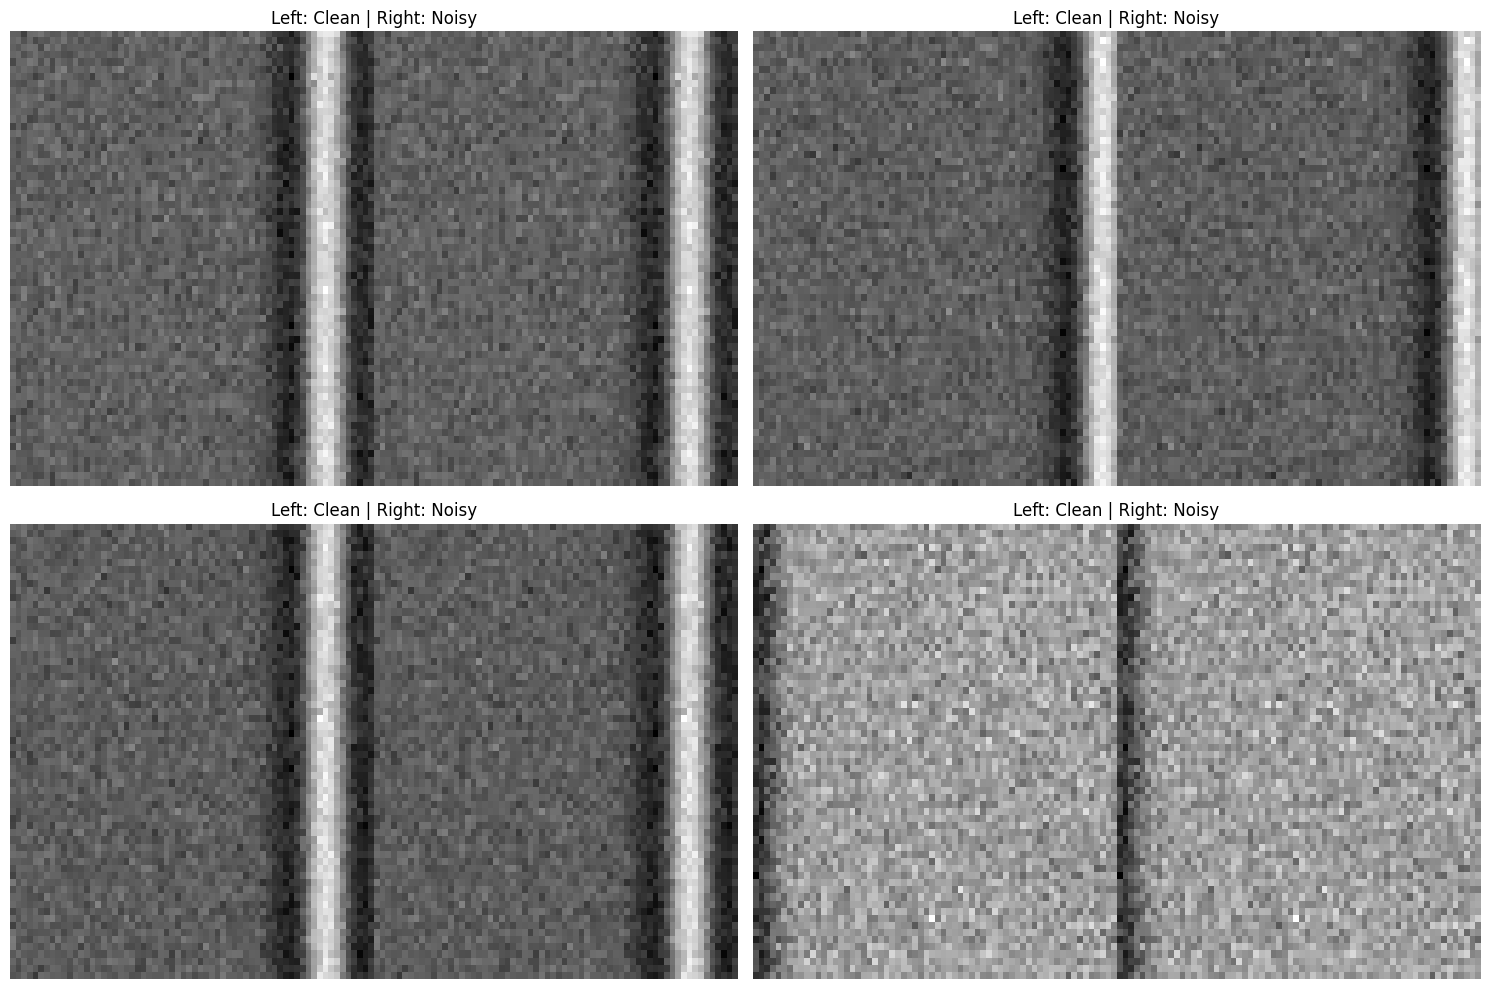

In [20]:
import os


def visualize_windows(clean_windows, noisy_windows, num_rows=2, num_cols=2):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for row in range(num_rows):
        for col in range(num_cols):
            idx = random.randint(0, len(clean_windows) - 1)
            clean_window = clean_windows[idx]
            noisy_window = noisy_windows[idx]

            axs[row, col].imshow(np.hstack((clean_window, noisy_window)), cmap='gray', aspect='auto')
            axs[row, col].set_title('Left: Clean | Right: Noisy')
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
print(os.getcwd())
h = 64
w = 64
batch_size = 4
#folder_path_train = 'drive/MyDrive/S2DS/Team CGG/Data/synth_data/data_input/train'
#folder_path_test =  'drive/MyDrive/S2DS/Team CGG/Data/synth_data/data_input/test'
folder_path_test=os.getcwd()
folder_path_train=os.getcwd()

train_generator = data_generator(folder_path_train, h, w, batch_size)
test_generator = data_generator(folder_path_test, h, w, batch_size)

clean_batch_train, noisy_batch_train = next(train_generator)
clean_batch_test, noisy_batch_test = next(test_generator)

print(clean_batch_test.shape)

visualize_windows(clean_batch_train, noisy_batch_train)


### Choosing an autoencoder model

In [22]:
# Importing necessary libraries
from tensorflow.keras import layers, models

def simple_autoencoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoding Path
    x = layers.Conv2D(16, (3, 3), activation='elu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoding Path
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)

    # Output layer with the original shape
    outputs = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(inputs, outputs)

input_shape = (64, 64, 1)
simple_autoencoder_model = simple_autoencoder(input_shape)
simple_autoencoder_model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       9248

In [ ]:

#Unet_scl = autoencoder('Unet_v3',kernel=(6,7),input_size=(32,70,1))
simple_autoencoder_model.compile(optimizer='adam', loss='mse', run_eagerly=True)
# Creating callback for training
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0005,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

note this data generator is good specifically if we want to use a binary classifier approach

In [ ]:
batch_size= 4
epochs = 5 # note should be a lot more
train_file_names = [f for f in os.listdir(folder_path_train) if f.endswith('.npy') and 'clean' in f]
import gc
gc.collect()

train_file_names = [f for f in os.listdir(folder_path_train) if f.endswith('.npy') and 'clean' in f]
# Training
simple_autoencoder_model.fit(train_generator,
             steps_per_epoch=4// batch_size,
             epochs=epochs,
             shuffle=True,
             use_multiprocessing=True)
             #callbacks=[callback])

# Evaluate the model on test data
#test_loss = simple_autoencoder.evaluate(test_generator, steps=len(test_file_names) // batch_size)
#print("Test loss:", test_loss)



Epoch 1/5


Process Keras_worker_ForkPoolWorker-8:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 131, in worker
    put((job, i, result))
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 377, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 405, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
KeyboardInterrupt
Exception in thread Thread-46 (_handle_results):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, i

In [ ]:
single_batch_input, single_batch_target = next(train_generator)
print(single_batch_input.shape)
loss = simple_autoencoder_model.train_on_batch(single_batch_input, single_batch_target)
print("Loss on single batch:", loss)


(1536, 64, 64)
Loss on single batch: 0.7389211654663086
